<a href="https://colab.research.google.com/github/diazid/projecto_clasificador_canes/blob/main/clasificacion_de_canes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de Canes usando Vision Computacional

Elaborado por: Andrea Faúndez Quezada - Israel Díaz García

Machine Learning Avanzado

Tutor: José García

## Desarrollo

El presente trabajo tiene por objeto construir un modelo que permita clasificar imágenes de canes según su raza. El dataset inicial consta de 20.580 imágenes, con 120 razas distintas.
Para abordar el problema se propone utilizar una Red Neuronal Convolucional (CNN) tipo inception V3 preentrenada dado que el imageset tiene pocas imágenes por cada clase como para entrenar una red desde cero, además de que aporta a mejorar la precisión del modelo. Esto se conoce como transfer learning.

Este Jupyter Notebook se ha ejecutado en Google Colab bajo un ambiente de GPU. Las características de la GPU pueden cambiar cada vez que se reinicia el ambiente, el siguiente codigo muestran el hardward asignado por colab.

In [1]:
#Características del la GPU
!nvidia-smi

Wed Nov 30 05:15:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

También, se ha utilizado Github como repositorio de datos, ya que Google Drive es ineficiente y lento para manejar grandes volúmenes de datos. El siguiente código recupera el dataset desde GitHub.

In [2]:
#Recuperar el dataset desde Github
!git clone https://github.com/diazid/projecto_clasificador_canes.git

#El imageset utilizado se puede encontrar en la siguiente direccióón web: http://vision.stanford.edu/aditya86/ImageNetDogs/

Cloning into 'ProyectoMLA'...
remote: Enumerating objects: 41327, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 41327 (delta 0), reused 7 (delta 0), pack-reused 41320
Receiving objects: 100% (41327/41327), 737.77 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (20274/20274), done.
Checking out files: 100% (41163/41163), done.


In [3]:
!ls

ProyectoMLA  sample_data


### Carga de librerías a utilizar

In [4]:
import numpy as np
import pandas as pd 
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET #para leer annotate
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets, models
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn
import pathlib
from collections import Counter

Después cargar las libreías necesarias, se chequea si pytorch reconoce el hardware GPU asignado por colab.

In [5]:
torch.cuda.is_available()

True

### Carga de imágenes y anotaciones

In [6]:
path_img = '/content/projecto_clasificador_canes/data/Images/' 
path_annot = '/content/projecto_clasificador_canes/data/Annotation/'

lista_razas = os.listdir(path_img)
lista_razas.sort()
num_clases = len(lista_razas)
print('{} razas'.format(num_clases))

n_total_imagenes = 0
for raza in lista_razas:
    n_total_imagenes += len(os.listdir(path_img+'{}'.format(raza)))
print('{} imagenes'.format(n_total_imagenes))

120 razas
20580 imagenes


Como se muestra en el resultado, el image set son 120 folders (cada uno es una raza), y en total hay 20580 imagenes para procesar. 

### Mapeo de clases

Se procede a mapear clases, que corresponden a las diferentes razas presentes en el imageset. Esta información será utilizada posteriormente para tratar las imagenes de forma que estén formateadas y conocer la relación entre variable target y clase al momento de entrenar la red convolucional. 

In [7]:
mapa_etiqueta = {}
mapa_etiqueta_rev = {}
for i,v in enumerate(lista_razas):
  mapa_etiqueta.update({i:v})
mapa_etiqueta

{0: 'Affenpinscher',
 1: 'Afghan_hound',
 2: 'African_hunting_dog',
 3: 'Airedale',
 4: 'American_Staffordshire_terrier',
 5: 'Appenzeller',
 6: 'Australian_terrier',
 7: 'Basenji',
 8: 'Basset',
 9: 'Beagle',
 10: 'Bedlington_terrier',
 11: 'Bernese_mountain_dog',
 12: 'Black-and-tan_coonhound',
 13: 'Blenheim_spaniel',
 14: 'Bloodhound',
 15: 'Bluetick',
 16: 'Border_collie',
 17: 'Border_terrier',
 18: 'Borzoi',
 19: 'Boston_bull',
 20: 'Bouvier_des_Flandres',
 21: 'Boxer',
 22: 'Brabancon_griffon',
 23: 'Briard',
 24: 'Brittany_spaniel',
 25: 'Bull_mastiff',
 26: 'Cairn',
 27: 'Cardigan',
 28: 'Chesapeake_Bay_retriever',
 29: 'Chihuahua',
 30: 'Chow',
 31: 'Clumber',
 32: 'Cocker_spaniel',
 33: 'Collie',
 34: 'Curly-coated_retriever',
 35: 'Dandie_Dinmont',
 36: 'Dhole',
 37: 'Dingo',
 38: 'Doberman',
 39: 'English_foxhound',
 40: 'English_setter',
 41: 'English_springer',
 42: 'EntleBucher',
 43: 'Eskimo_dog',
 44: 'Flat-coated_retriever',
 45: 'French_bulldog',
 46: 'German_sheph

### Previsualización 
#### Imágenes originales

In [8]:
def mostrar_imagenes_dir(raza, path_img, cant_img):
    '''
    Esta función al ejecutarla devuelve una cantidad de imagenes solicitada. 
    Argumentos: 
    "raza" corresponde el folder donde se encuentran las imagenes de determinada raza, 
    "path_img" es la dirección en disco de donde se encuentra dicha carpeta, 
    "cant_img" es la cantidad de imagenes que se desean visualizar. 
    '''

    plt.figure(figsize=(16,16))
    img_dir = path_img+"{}/".format(raza)
    images = os.listdir(img_dir)[:cant_img]
    for i in range(cant_img):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(cant_img/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

Imágenes de la clase: Affenpinscher


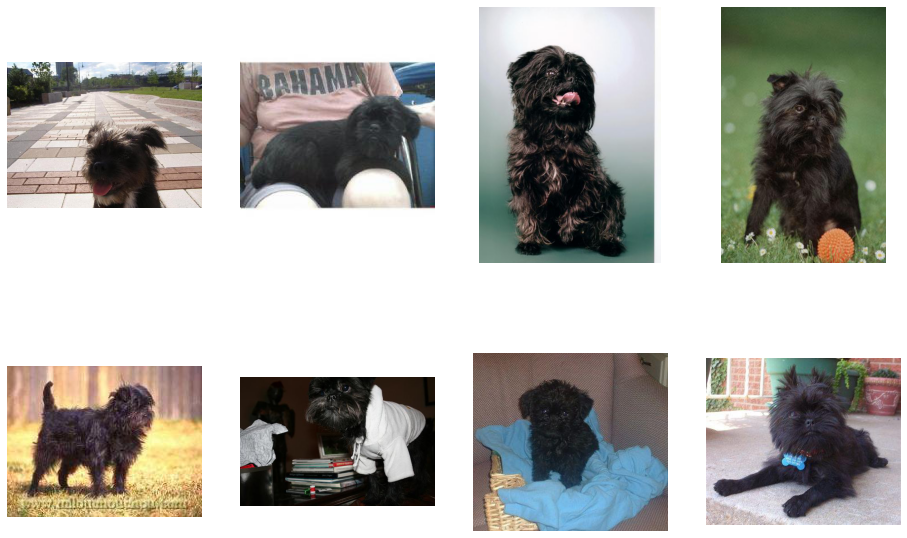

In [9]:
print('Imágenes de la clase: {}'.format(lista_razas[0]))
mostrar_imagenes_dir(lista_razas[0], path_img,8)

Como se puede ver, las imágenes son variadas. Contienen perros en diferentes situaciones y backgrounds. Esto añade dificultad a la hora de ejecutar el proceso de clasificación ya que la imagen contiene elementos que no son útiles, o añaden ruido.

Estos elementos se pueden eliminar antes de entrenar la red, con la finalidad de solo contener el perro en el cuadro. Para ello el imageset contiene un archivo de metadatos por imagen, en el cual se encuentra el cuadro contenedor del perro en la imagen, entre otros datos que para estudio no vienen al caso. 

Dicho esto, se ejecuta el código para recortar la imagen con el contenedor del perro, y un tamaño de imagen de 299 x 299 pixeles. 

In [10]:
%%time 

from PIL import Image

#Se crea una carpeta llamada working para contener las imagenes recortadas
if not os.path.exists('/content/projecto_clasificador_canes/working/'):
    os.mkdir('/content/projecto_clasificador_canes/working/')
    
for raza in lista_razas:
    if not os.path.exists('/content/projecto_clasificador_canes/working/' + raza):
        os.mkdir('/content/projecto_clasificador_canes/working/' + raza)

print('Se han creado {} carpetas para almacenar diferentes imagenes recortada de los perros.'.format(len(os.listdir('/content/ProyectoMLA/working/'))))

#Lee el archivo de metadatos, extrae las coordenadas del perro en la imagen, recorta la misma 
# y la guarda en un archivo nuevo con el mismo nombre
for raza in os.listdir('/content/projecto_clasificador_canes/working/'):
    for file in os.listdir(path_annot+'{}'.format(raza)):
        img = Image.open(path_img+'{}/{}.jpg'.format(raza, file))
        tree = ET.parse(path_annot+'{}/{}'.format(raza, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((299, 299))
        img.save('/content/projecto_clasificador_canes/working/' + raza + '/' + file + '.jpg')

Se han creado 120 carpetas para almacenar diferentes imagenes recortada de los perros.
CPU times: user 2min 38s, sys: 5.99 s, total: 2min 44s
Wall time: 2min 46s


Luego de realizado el proceso de recorte de imágenes, se procede a previsualizar el resultado del recorte de las mismas. 
#### Imágenes recortadas

In [11]:
# Prevualizando imagenes
path_img_d = '/content/projecto_clasificador_canes/working/'
lista_razas = os.listdir(path_img_d)
lista_razas.sort()

Raza: Affenpinscher


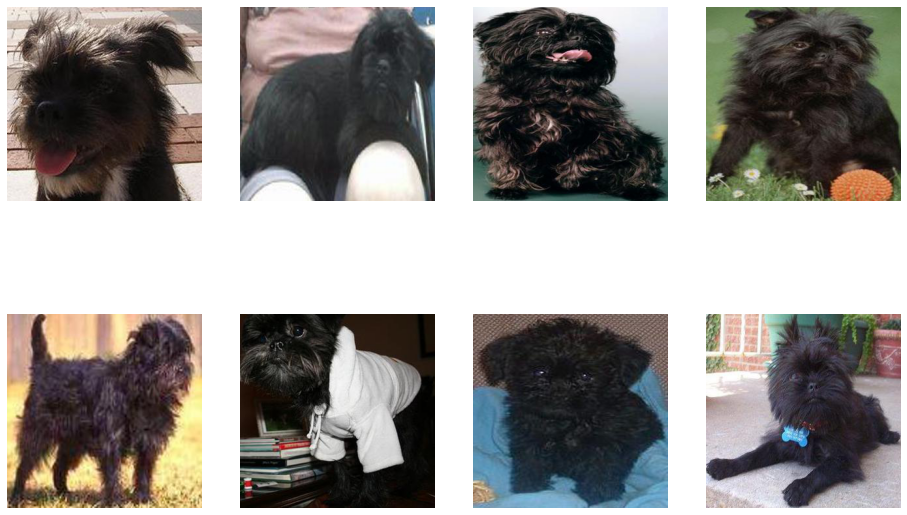

In [12]:
print('Raza: {}'.format(lista_razas[0]))
mostrar_imagenes_dir(lista_razas[0], path_img_d, 8)

### Exploración del Imageset

Para el proceso de clasificación en la red convolucional, es importante que la data se encuentre balanceada, o que las clases se encuentren balanceadas en este caso. 

Si la data se encuentra desbalanceada, o que existen muchas imágenes en una clase y pocas en otra, es posible que el modelo creado presente un sesgo a la hora de realizar el proceso de clasificación, ya que priorizará una clase sobre la otra. 

In [13]:
%%time
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder('/content/projecto_clasificador_canes/working/', transform=transform)

cuenta_clases = {}
for i in range (len(dataset)):
    if str(dataset[i][1]) not in cuenta_clases:
        cuenta_clases[str(dataset[i][1])]=1
    else:
        cuenta_clases[str(dataset[i][1])]+=1

CPU times: user 1min 42s, sys: 15 s, total: 1min 57s
Wall time: 1min 57s


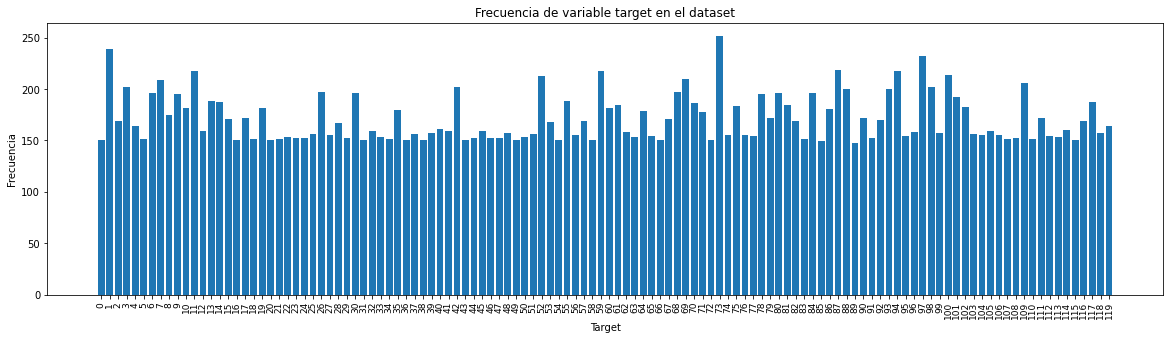

In [14]:
plt.figure(figsize=(20,5))
plt.bar(cuenta_clases.keys(), cuenta_clases.values())
plt.xticks(rotation=90,fontsize=9)
plt.title('Frecuencia de variable target en el dataset')
plt.ylabel('Frecuencia')
plt.xlabel('Target')

plt.show()

In [15]:
min(cuenta_clases.values())

148

Se observa que las clases minoritarias tienen 148 imágenes de perros de la misma raza. 

En general, la data se encuentra bastante balanceada. El caso ideal es tener la misma cantidad de imágenes por clase, sin embargo, dada la poca cantidad de imágenes por clases, se intentará re-entrenar el modelo con la cantidad original.

### Separación de la data en train - validation - test

Se realizan particiones a fin de contar con un conjunto de entrenamiento del 60% del dataset total, conjunto de validación del 20% y conjunto de testing del 20%.

In [16]:
batch_size = 128  #Tamaño de batch para procesar
torch.manual_seed(123) #Semilla para random_split

'''Se define la transformación a utilizar en cada uno de los conjuntos.
Los parámetros de esta transformación se utilizan porque son los mismos que 
fueron usados previamente para pre-entrenar el modelo "models.inception_v3". 
Por esta razón se considera usar estos parámetros para entrenar las capas que 
lo requieran.
'''
image_transforms = {
    'transform':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Requerimiento Imagenet
    ])
}
#Carga de imágenes procesadas
data_imgs = datasets.ImageFolder(path_img_d)
#Definición de tamaño de los conjuntos ~ 60%-20%-20%
train_data_len = int(len(data_imgs)*0.6) 
valid_data_len = int((len(data_imgs) - train_data_len)/2)
test_data_len = int(len(data_imgs) - train_data_len - valid_data_len)
#División del dataset
train_data, val_data, test_data = random_split(data_imgs, [train_data_len, valid_data_len, test_data_len])
#Aplicación de la transformación definida previamente
train_data.dataset.transform = image_transforms['transform']
val_data.dataset.transform = image_transforms['transform']
test_data.dataset.transform = image_transforms['transform']
#Tamaño de las particiones
print('Tamaño Train set: \t{} imágenes \nTamaño Validation set: \t{} imágenes \nTamaño Test set: \t{} imágenes'
.format(len(train_data), len(val_data), len(test_data)))
#Cargadores de datos
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Tamaño Train set: 	12348 imágenes 
Tamaño Validation set: 	4116 imágenes 
Tamaño Test set: 	4116 imágenes


In [17]:
#Tensores
features, labels = next(iter(train_loader))
#Muestra las dimensiones de un batch del cargador de datos
print(features.shape, labels.shape)

torch.Size([128, 3, 299, 299]) torch.Size([128])


Luego de realizar el split del imageset en entrenamiento, validación y test, se procede a explorar como han quedado la distribución de la clases en cada uno uno de los subsets generados. 

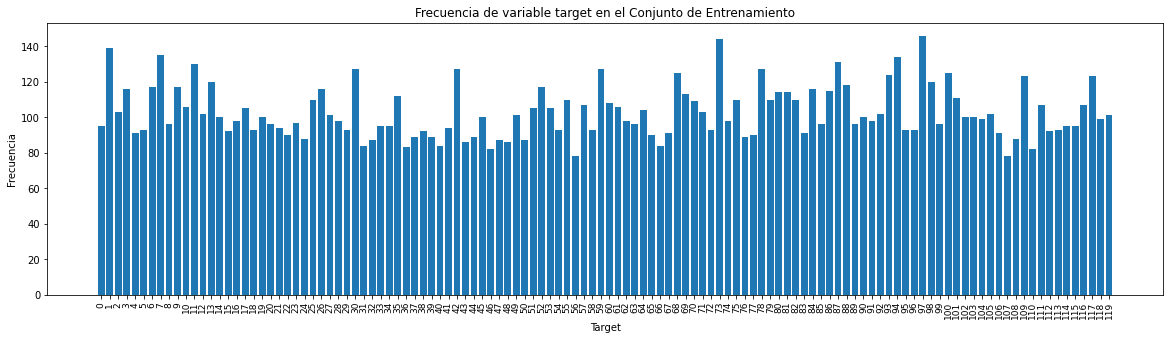

In [18]:
torch.manual_seed(123)
train_targets=[]
for batch_idx, (data, target) in enumerate(train_loader):
  train_targets+=target.tolist()
train_targets.sort()
train_targets = [str(i) for i in train_targets]
plt.figure(figsize=(20,5))
plt.bar(Counter(train_targets).keys(), Counter(train_targets).values())
plt.xticks(rotation=90,fontsize=9)
plt.title('Frecuencia de variable target en el Conjunto de Entrenamiento')
plt.ylabel('Frecuencia')
plt.xlabel('Target')

plt.show()
del train_targets

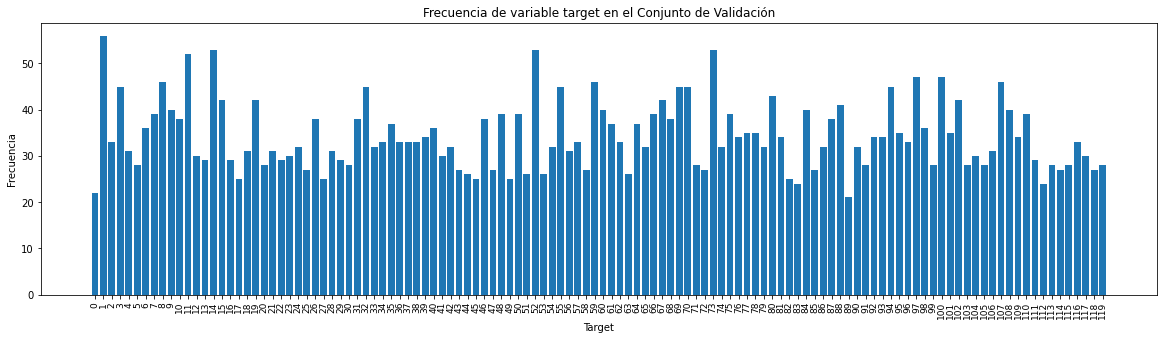

In [19]:
torch.manual_seed(123)
val_targets=[]
for batch_idx, (data, target) in enumerate(val_loader):
  val_targets+=target.tolist()
val_targets.sort()
val_targets = [str(i) for i in val_targets]
plt.figure(figsize=(20,5))
plt.bar(Counter(val_targets).keys(), Counter(val_targets).values())
plt.xticks(rotation=90,fontsize=9)
plt.title('Frecuencia de variable target en el Conjunto de Validación')
plt.ylabel('Frecuencia')
plt.xlabel('Target')

plt.show()
del val_targets

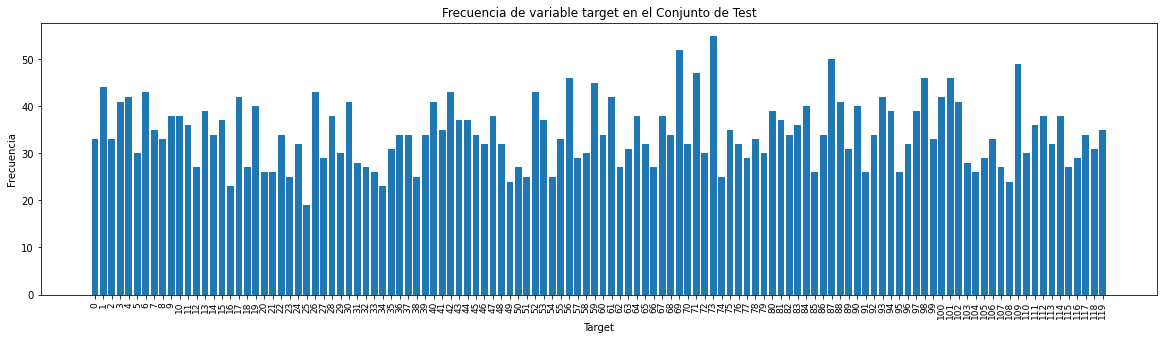

In [20]:
torch.manual_seed(123)
test_targets=[]
for batch_idx, (data, target) in enumerate(test_loader):
  test_targets+=target.tolist()
test_targets.sort()
test_targets = [str(i) for i in test_targets]
plt.figure(figsize=(20,5))
plt.bar(Counter(test_targets).keys(), Counter(test_targets).values())
plt.xticks(rotation=90,fontsize=9)
plt.title('Frecuencia de variable target en el Conjunto de Test')
plt.ylabel('Frecuencia')
plt.xlabel('Target')

plt.show()
del test_targets

Como se ve en el conjunto de entrenamiento se ha mantenido una distribución muy similar en las clases respecto del imageset original. 

## Red Neuronal

Se utiliza una Red Neuronal Convolucional Inception V3, que ha sido desarrollada para optimizar el proceso de computo, a la vez que mejora el accuracy. Esta red preentrenada será utilizada para resolver el problema de clasificación de imágenes de perros según su raza, disminuyendo el tiempo de entrenamiento con el dataset.

Paper: [Inception_V3](https://arxiv.org/pdf/1512.00567v3.pdf)

![Arquitectura Inception_V3](https://miro.medium.com/max/1400/1*gqKM5V-uo2sMFFPDS84yJw.png)

#### La Premisa 
El autor del paper notó que clasificadores auxiliares no contribuian mucho sino hasta muy cerca de la finalización del proceso de entrenamiento, cuando los `accuracies` se acercan a la saturación. Argumenta que funcionan como regularizaciones, especialmente si tienen operaciones BatchNorm o Dropout. Vió una oportunidad de mejora de la arquitectura Inception_V2.

#### La Solución

Inception Net v3 incorpora todas las actualizaciones anteriores indicadas para Inception v2, y además utiliza lo siguiente:

* Optimizador RMSProp.
* Convoluciones 7x7 Factorizadas.
* BatchNorm en el clasificador auxiliar
* Suavizado de etiquetas, un tipo de componente de regularización agregado a la fórmula de pérdida que evita que la red tenga demasiada confianza en una clase. Previene el ajuste excesivo (overfitting).

Se invita a leer el Paper para más información.

A continación se importa el model preentrenado, para ello se utiliza la funcióón models.inception_v3 con el argumento pretrained=True. 

In [21]:
%%time
model = models.inception_v3(pretrained=True)
model.aux_logits=False

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

CPU times: user 855 ms, sys: 294 ms, total: 1.15 s
Wall time: 5.49 s


Si se llama al modelo (model) este mostrará la arquitectura del mismo. 

In [22]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Como se puede ver, es una arquitectura compleja, con kernels de distintas dimensiones. Adicionalemente, se le exige al modelo que no reentrene las primeras capas, este proceso se conoce como freezing. 

In [23]:
# No entrenar primeras capas 
for param in model.parameters():
    param.requires_grad = False

La red neuronal full connected al final del proceso de la red convolucional está diseñada para trabajar con 1000 clases de salida. Esto no es util para nuestro modelo de clasificación, ya que nosotros solo temos 120 clases. Por este motivo se reemplazará la red full connected por otra que tenga 120 neuronas de salida correspondientes a las 120 razas que se requiere clasificar. 

In [24]:
#Solo se entrenarán las capaz del clasificador:
n_clases = 120
n_inputs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, n_clases),
    nn.LogSoftmax(dim=1))

In [25]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=1024, out_features=120, bias=True)
  (4): LogSoftmax(dim=1)
)

Se ha configurado la NN para que vaya de 2048 neuronas a 120, para ellos se ha configurado una capa primera capa que va de 2048 a 1024, con un función de activación ReLU, y un DropOut de 0.4, esto se hace para que la red en cada `epoch` apague el 40% de las neuronas  de forma aleatoria y de esta forma la red aprenda reconocer caracteristicas de diferentes formas. Después otra capa que va de 1024 neuronas a 120 neuronas de salida, y al final una capa de LogSoftMax, que no es mas que una función SoftMax seguido de logaritmo.

El siguiente código envía el modelo para su ejecución en el hardward GPU, si este paso no se realiza entonces el modelo se ejecuta en la CPU, lo cual tarda mucho tiempo en ejecutarse y producir el resultado.

In [26]:
# enviar el modelo a la GPU en lugar de CPU
model.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [27]:
# indice para las 120 clases
model.class_to_idx = data_imgs.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'Affenpinscher'),
 (1, 'Afghan_hound'),
 (2, 'African_hunting_dog'),
 (3, 'Airedale'),
 (4, 'American_Staffordshire_terrier'),
 (5, 'Appenzeller'),
 (6, 'Australian_terrier'),
 (7, 'Basenji'),
 (8, 'Basset'),
 (9, 'Beagle'),
 (10, 'Bedlington_terrier'),
 (11, 'Bernese_mountain_dog'),
 (12, 'Black-and-tan_coonhound'),
 (13, 'Blenheim_spaniel'),
 (14, 'Bloodhound'),
 (15, 'Bluetick'),
 (16, 'Border_collie'),
 (17, 'Border_terrier'),
 (18, 'Borzoi'),
 (19, 'Boston_bull'),
 (20, 'Bouvier_des_Flandres'),
 (21, 'Boxer'),
 (22, 'Brabancon_griffon'),
 (23, 'Briard'),
 (24, 'Brittany_spaniel'),
 (25, 'Bull_mastiff'),
 (26, 'Cairn'),
 (27, 'Cardigan'),
 (28, 'Chesapeake_Bay_retriever'),
 (29, 'Chihuahua'),
 (30, 'Chow'),
 (31, 'Clumber'),
 (32, 'Cocker_spaniel'),
 (33, 'Collie'),
 (34, 'Curly-coated_retriever'),
 (35, 'Dandie_Dinmont'),
 (36, 'Dhole'),
 (37, 'Dingo'),
 (38, 'Doberman'),
 (39, 'English_foxhound'),
 (40, 'English_setter'),
 (41, 'English_springer'),
 (42, 'EntleBucher'),
 (43

### Training Model

In [28]:
%%time
def train(model, criterion, optimizer, train_loader, val_loader, save_location, early_stop=3, n_epochs=20, print_every=1):
    #Inicializando variables
    valid_loss_min = np.Inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0

    #Loop
    for epoch in range(n_epochs):

        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        model.train()
        ii = 0

        for data, label in train_loader:
            ii += 1
            data, label = data.cuda(), label.cuda()
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # Seguimiento del traing loss
            train_loss += loss.item() * data.size(0)

            # Calcula accuracy
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            if ii%10 == 0:
                print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')

        model.epochs += 1
        with torch.no_grad():
            model.eval()

            for data, label in val_loader:
                data, label = data.cuda(), label.cuda()

                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)

                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(label.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)

            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(val_loader.dataset)

            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(val_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            if (epoch + 1) % print_every == 0:
                print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

            if valid_loss < valid_loss_min:
                torch.save({
                    'state_dict': model.state_dict(),
                    'idx_to_class': model.idx_to_class
                }, save_location)
                stop_count = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                stop_count += 1

                #En el caso donde donde se llega al caso de early stop se ejecuta lo siguiente:
                if stop_count >= early_stop:
                    print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                    model.load_state_dict(torch.load(save_location)['state_dict'])
                    model.optimizer = optimizer
                    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
                    return model, history

    model.optimizer = optimizer
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


Se ejecuta la fución creada anteriormente para entrenar el modelo. Este proceso guardará el resultado en un archivo (dog_inception.pt) que posteriormente se podrá reutilizar sin necesidad de entrenar el modelo nuevamente.

In [29]:
%%time
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='/content/projecto_clasificador_canes/dog_inception.pt',
    early_stop=3,
    n_epochs=20,
    print_every=1)

Epoch: 0	11.34% complete.
Epoch: 0	21.65% complete.
Epoch: 0	31.96% complete.
Epoch: 0	42.27% complete.
Epoch: 0	52.58% complete.
Epoch: 0	62.89% complete.
Epoch: 0	73.20% complete.
Epoch: 0	83.51% complete.
Epoch: 0	93.81% complete.

Epoch: 0 	Training Loss: 3.1201 	Validation Loss: 1.2771
		Training Accuracy: 40.69%	 Validation Accuracy: 73.66%
Epoch: 1	11.34% complete.
Epoch: 1	21.65% complete.
Epoch: 1	31.96% complete.
Epoch: 1	42.27% complete.
Epoch: 1	52.58% complete.
Epoch: 1	62.89% complete.
Epoch: 1	73.20% complete.
Epoch: 1	83.51% complete.
Epoch: 1	93.81% complete.

Epoch: 1 	Training Loss: 1.1600 	Validation Loss: 0.8107
		Training Accuracy: 70.77%	 Validation Accuracy: 78.30%
Epoch: 2	11.34% complete.
Epoch: 2	21.65% complete.
Epoch: 2	31.96% complete.
Epoch: 2	42.27% complete.
Epoch: 2	52.58% complete.
Epoch: 2	62.89% complete.
Epoch: 2	73.20% complete.
Epoch: 2	83.51% complete.
Epoch: 2	93.81% complete.

Epoch: 2 	Training Loss: 0.8852 	Validation Loss: 0.7028
		Training

In [30]:
history

,train_loss,valid_loss,train_acc,valid_acc
0,3.120145,1.277146,0.406868,0.736638
1,1.159968,0.810662,0.707726,0.783042
2,0.885199,0.702775,0.753644,0.807094
3,0.779651,0.671606,0.772757,0.808066
4,0.713280,0.644573,0.790654,0.808552
5,0.667995,0.638592,0.798915,0.814140
6,0.617525,0.644082,0.812763,0.807823
7,0.587900,0.616767,0.816408,0.816812
8,0.554027,0.608543,0.831228,0.821914
9,0.538821,0.625874,0.832523,0.812682


A continuación, se grafican los resutlados para ver la evolución del proceso de entrenamiento. 

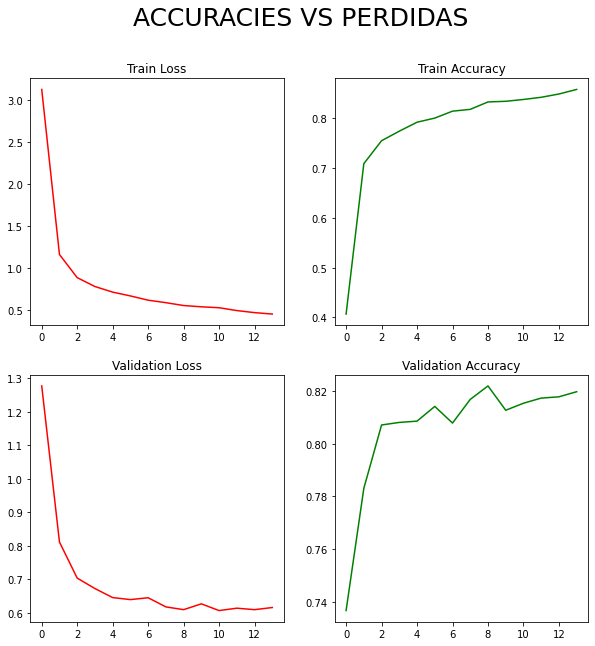

In [31]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].plot(history.index, history.train_loss, color='red')
ax[0,0].set_title('Train Loss')
ax[0,1].plot(history.index, history.train_acc, color='green')
ax[0,1].set_title('Train Accuracy')
ax[1,0].plot(history.index, history.valid_loss, color='red')
ax[1,0].set_title('Validation Loss')
ax[1,1].plot(history.index, history.valid_acc, color='green')
ax[1,1].set_title('Validation Accuracy')

plt.suptitle('ACCURACIES VS PERDIDAS', size=25)
plt.show()

Los resultados de cada iteración se observan en los gráficos, donde en la epoch 12 se obtiene la mejor combinación de accuracy mayor y menor pérdida. El mejor accuracy para el conjunto de validación es de 0.815841, con pérdida de 0.603322.

### Testing

Se procede a ejecutar el proceso de testing del modelo con los datos de prueba. 

In [32]:
def test(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()

            output = model(data)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)

        test_acc = test_acc / len(test_loader.dataset)
        return test_acc

In [33]:
model.load_state_dict(torch.load('/content/projecto_clasificador_canes/dog_inception.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'El modelo ha alcanzado un accuracy de {100 * test_acc:.2f}% sobre el imageset test')

El modelo ha alcanzado un accuracy de 81.12% sobre el imageset test


Como vemos en el resultado el modelo a logrado un accuracy de 80.78 sobre el set de prueba (test). Lo cual es bastante bueno para este set de datos. 

A continuación se graficará la matriz de confusión sobre los resultados en aras de ver por clase la cantidad de aciertos. 

In [34]:
nb_classes = 120
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[17.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 55.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 31.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 22.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., 11.,  0.],
        [ 1.,  0.,  0.,  ...,  0.,  0., 21.]])


Matriz de Confusión sin normalización
tensor([[17.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 55.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 31.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 22.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., 11.,  0.],
        [ 1.,  0.,  0.,  ...,  0.,  0., 21.]])


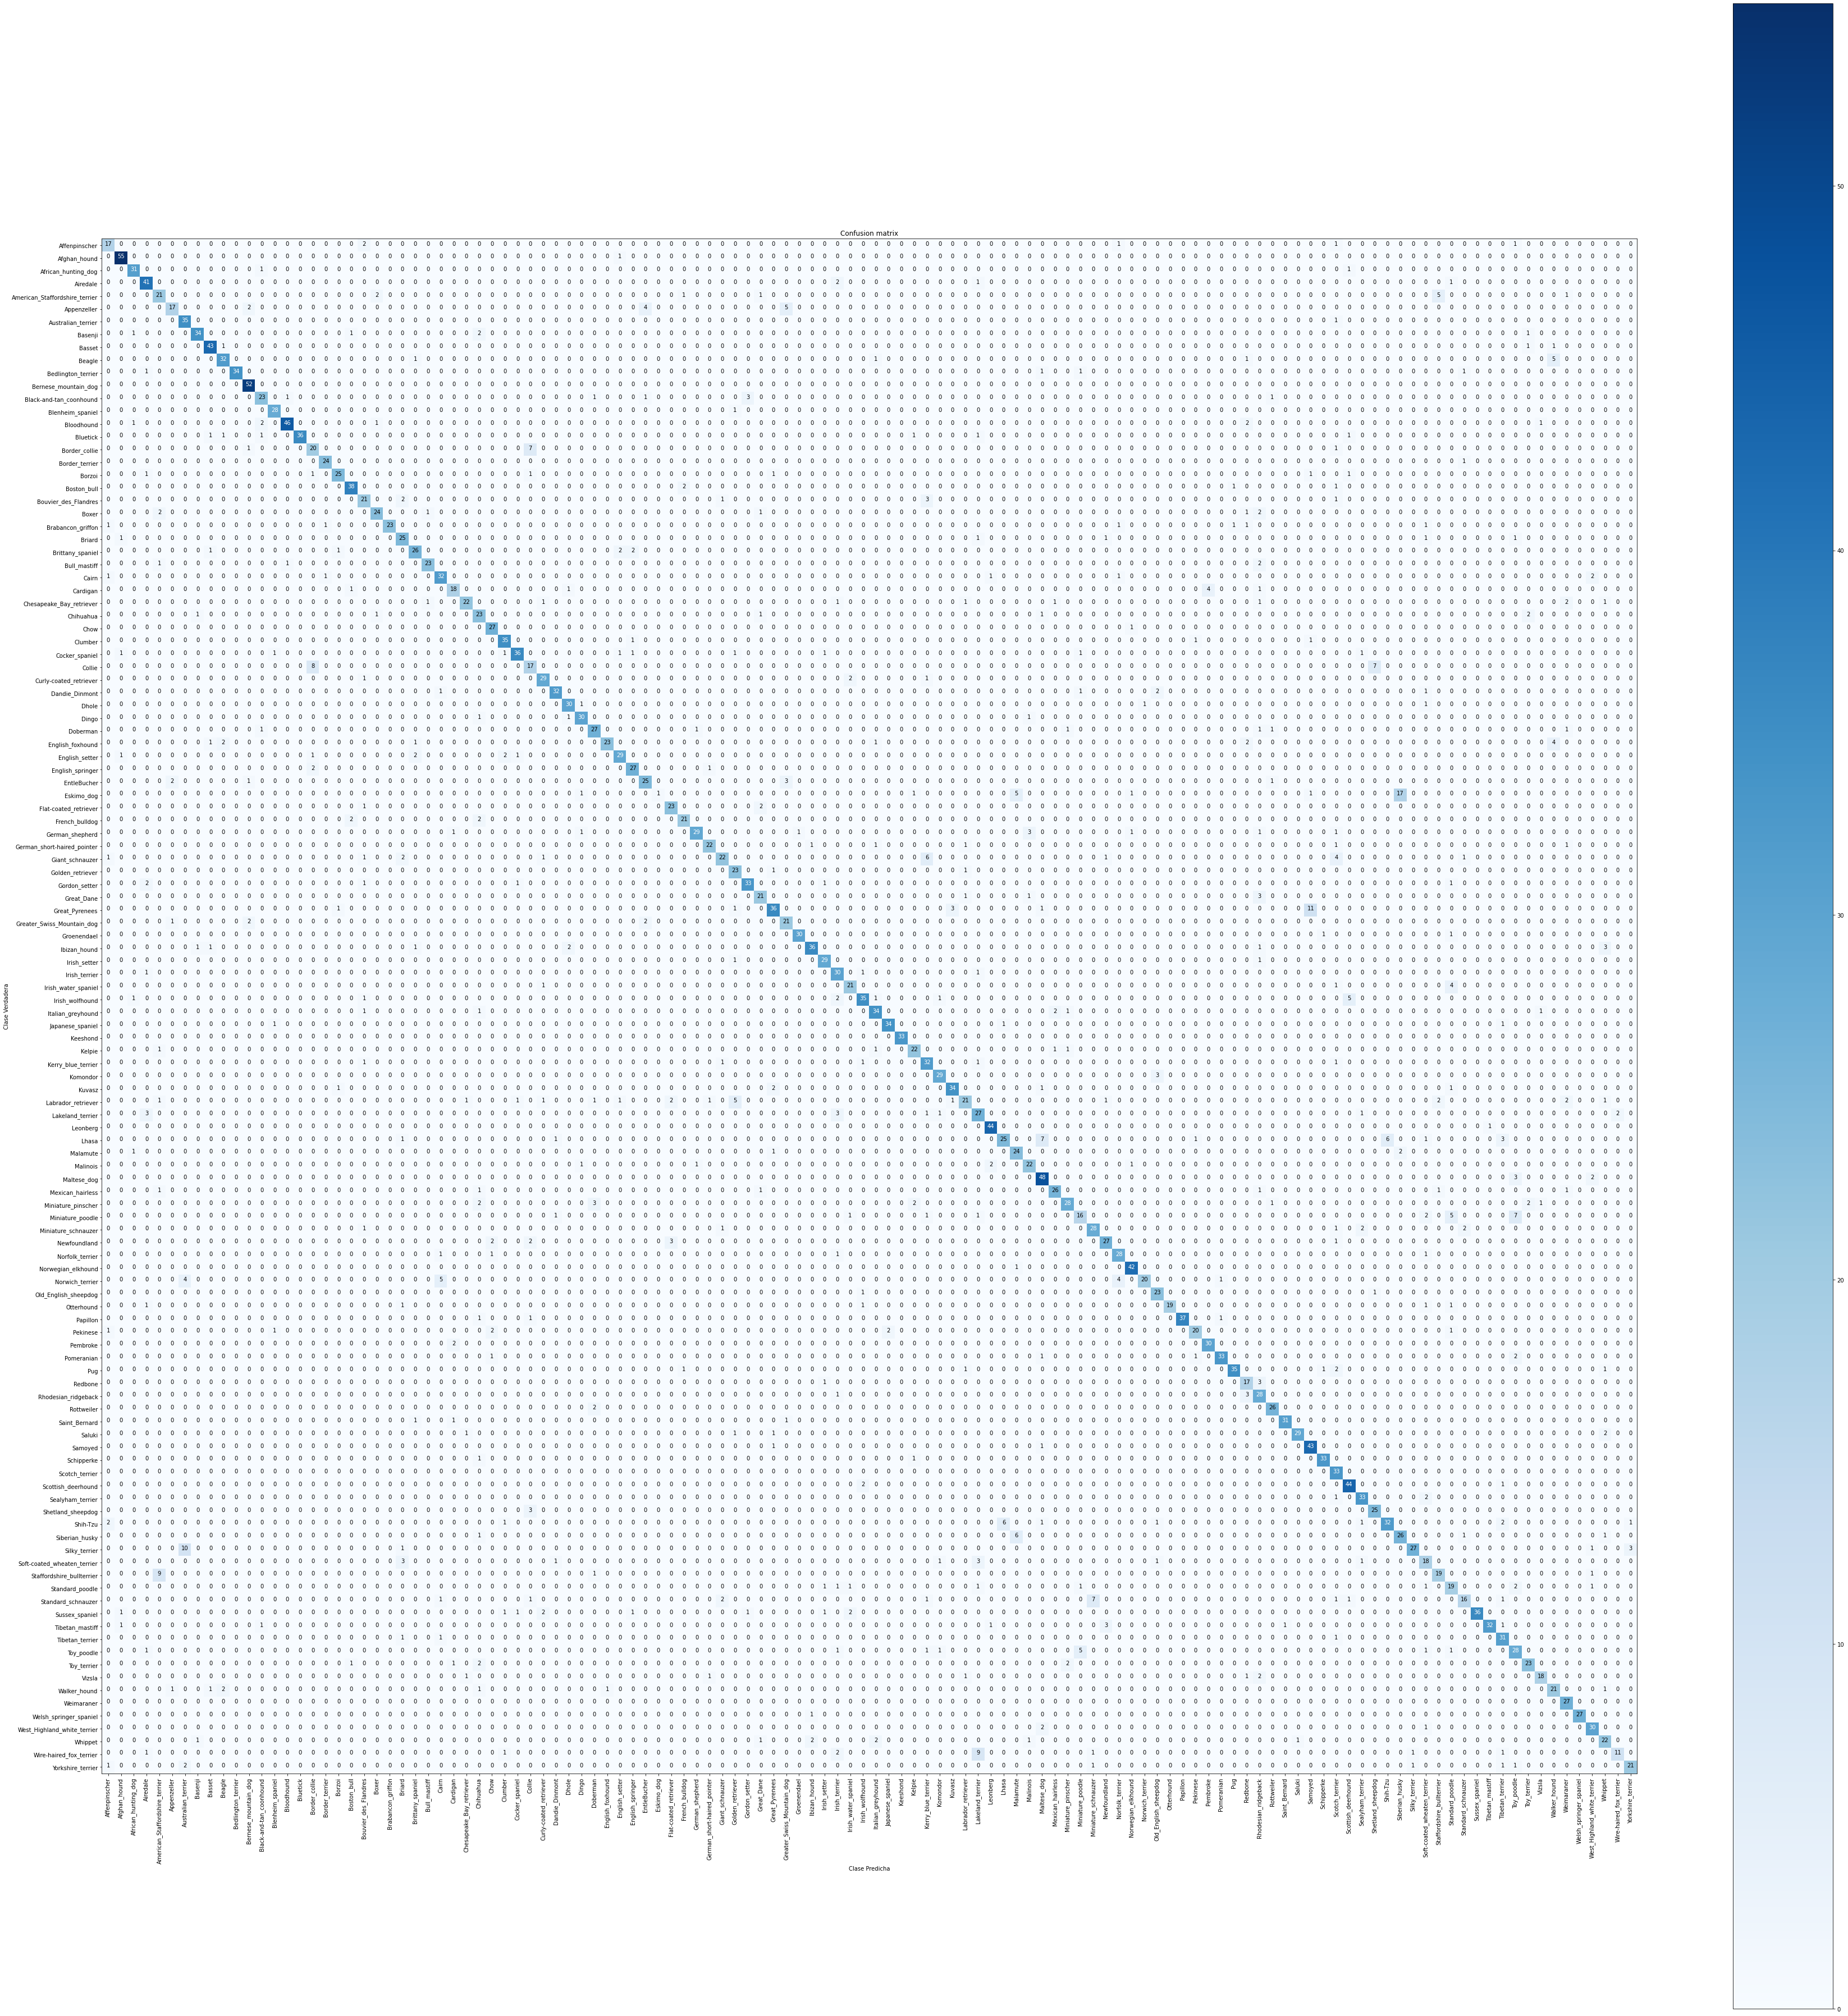

In [35]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusión normalizada")
    else:
        print('Matriz de Confusión sin normalización')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' #if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')

plt.figure(figsize=(50,50))
plot_confusion_matrix(confusion_matrix, dataset.classes)

In [36]:
recall = {}
for i in range(len(confusion_matrix)):
  TP = confusion_matrix[i][i].item()
  FN = (confusion_matrix.sum(1)[i]-confusion_matrix[i][i]).item()
  recall[i] = round((TP)/(TP+FN)*100,2)
import operator
recall_sort = sorted(recall.items(), key=operator.itemgetter(1), reverse=False)
m = 0
b = 0
for i in recall:
  if  recall[i] < 75:
    m+=1
  elif recall[i]>=75:
    b+=1
print('Proporción de clases con recall superior a 0.75: {:.2f}%'.format(b/(b+m)*100))
print('Clases con mejor recall:', recall_sort[:5])
print('Clases con peor recall:',recall_sort[-5:])

Proporción de clases con recall superior a 0.75: 77.50%
Clases con mejor recall: [(43, 3.7), (118, 40.74), (76, 47.06), (67, 50.0), (106, 51.61)]
Clases con peor recall: [(1, 98.21), (11, 100.0), (62, 100.0), (96, 100.0), (114, 100.0)]


## Conclusiones

* Como se aprecia en los resultados la red neuronal convolucional Inception_V3 preentrenada es una buena arquitectura para realizar procesos de clasificaciones de imágenes.

* Se observa que de las 120 clases, el 70.83% presenta recall igual o superior a 0.75, mientras que el 29.17% de las clases tienen un recall inferior a 0.75.

* Lo anterior muestra un espacio de mejora para aquellas clases que el modelo no logra distinguir correctamente. En este aspecto, se podría aumentar la data de aquellas clases y luego re-entrenar el modelo.

* Adicionalmente, para futuros estudios se podría intentar reentrenar las primeras capas de la red neuronal con la data de los canes, para evaluar si esto mejora la capacidad predictiva del modelo, observando las métricas. 